<font size="2"> 

### **EN2550 Assignment 2 on Fitting and Alignment** 
+ *by Rajapaksha R.M.P.A.P. - 190484T* 
+ *Github Repository -*
+ *Email -* 
#### Question 1 - Using RANSAC method for finding the best fitting circle 
- step 1 - randomly choose a set of 3 points from the data set.
- step 2 - find the *circumscribed circle* of the triangle formed by the selected 3 points. 
- step 3 - finding the *Inlier* count of the model. 
> + Here, the Inliers are the points that reside within a certain threshold distance $t$ from the circumference of the estimated circle. As given in the code snippet *Listing 1*, these inliers are distributed according to a *Gaussian distribution* with a *variance* value $\sigma$ equal to $1/16$ times the radius of the original circle. 
> + Therefore, an expression for the threshold value $t$ can be found in terms of the radius of the estimated circle $r$, such that $95$% of the points of inliers are covered by the threshold limit as $ t = 1.96\sigma \ {\small (from \ Standard \ Normal \ Distribution \ Tables)} \Longrightarrow t = 1.96 \times r/16 = 0.1225 \ r$.  
> + Furthermore, if we assume that the estimated circle has a radius around length $10$ (as given in the code), then a single value can be given as a common threshold for all estimations. $ t_{common} = 0.1225 \times 10 = 1.225 $ 
- step 4 - if there are $d$ or more inliers, accept the estimation. 
> + To decide whether an estimation is exactly a good fitting model, its inlier count must exceed a certain limit, which is known as the *consensus set size* $d$. 
> + Since there are 50 inliers for the circle, and a good fitting model is expected to cover at least a 95% of those points, the consensus set size $d$ can be found as 
$ d = 0.95 \times halfn = 0.95 \times 50 = 47.5 \backsimeq 47 $. 

Store the data about the estimated circle and its inliers in a dictionary. 

This above process has to be repeated over a number of times to ensure that there is a sufficient probability that at least one sample would be free of any outlier. If the targeted probability of having at least one successful uncontaminated estimation is $p$ and the outlier ratio is $e$, then the number of repetition required to achieve $p$ can be found by the equation; 
$ N = log(1-p) / log(1 - (1-e)^s) $. 

Let us assume a reasonably higher $p$ value as $0.99$ [i.e. a $99$% success rate]. And it is easier to see that the outlier ratio $e$ is equal to $50$%. Thus, a minimum value for $N$ can be found out as follows. $ N = log(1-0.99) / log(1 - (1-0.5)^3) \Longrightarrow N = 34.48 \backsimeq 35 $ 

Finally, the circle with the maximum inlier count is chosen as the **best estimated circle** for the point distribution. Then using the *Least-Squares Circle Fit* method proposed by *Randy Bullock*, the **best-fit circle** will be determined for the inlier points of the best estimation. If there are more than one estimation with the maximum inlier count, then the refitted circle with the smallest mean error will be considered to be the best fit. 

In [49]:
# importing libraries 
import numpy as np
from scipy import linalg 
from scipy.optimize import minimize 
import cv2 as cv 
import matplotlib.pyplot as plt 
%matplotlib inline 

In [87]:
def leastSquaresFitCircle(points): 
    "finds the best fitting circle for a set of inlier points using the Least-Square Fitting Algorithm" 
    N = len(points); x_ = sum(points[:, 0])/N; y_ = sum(points[:, 1])/N # mean values 
    u = np.array([(xi-x_) for xi in points[:, 0]]); v = np.array([(yi-y_) for yi in points[:, 1]]) 
    Suu = sum([ui**2 for ui in u]);  Svv = sum([vi**2 for vi in v])
    Suv = Svu = sum([ui*vi for ui in u for vi in v]) 
    Suuu = sum([ui**3 for ui in u]); Svvv = sum([vi**3 for vi in v])
    Suvv = sum([ui*vi**2 for ui in u for vi in v]); Svuu = sum([vi*ui**2 for ui in u for vi in v])

    A = np.array([[Suu, Suv], 
                  [Svu, Svv]]) 
    B = np.array([[1/2 * (Suuu + Suvv)],
                  [1/2 * (Svvv + Svuu)]])
    (uc, vc) = ((np.linalg.inv(A) @ B).T).reshape(2)    
    (xc, yc) = (uc + x_, vc + y_)                   # center 
    R = np.sqrt(uc**2 + vc**2 + (Suu+Svv)/N)        # radius 
    mean_Error = sum([abs((xi-xc)**2 + (yi-yc)**2 - R**2) for (xi, yi) in points])/N 
    return (xc, yc, R, mean_Error) 

def RANSACcircle(points, N, t, d): 
     "finds the best fitting circle for a given point set using RANSAC method" 
     trial = 0; CircleDict = {} 
     while (trial < N): # perform N number of estimations 

          # --------------- randomly choose a set of 3 points from the point set --------------- 
          (i1, i2, i3) = np.random.randint(0, len(points), 3)    # finding 3 random indices in 'points' array
          if (len(set((i1, i2, i3))) < 3): N += 1; continue      # if the points are not distinct, then reject the sample
          x1, y1 = points[i1]; x2, y2 = points[i2]; x3, y3 = points[i3]

          # ----- finding the circumscribed circle of the triangle formed by the 3 points ------
          A = np.array([[(x1-x2), (y1-y2)], 
                        [(x1-x3), (y1-y3)]])
          B = np.array([[1/2 * (x1**2-x2**2 + y1**2-y2**2)],
                        [1/2 * (x1**2-x3**2 + y1**2-y3**2)]])
          center = ((np.linalg.inv(A) @ B).T).reshape(2) 
          xO = center[0]; yO = center[1]          # circumcenter 
          r = np.sqrt((x1-xO)**2 + (y1-yO)**2)    # radius 

          if (r > 12) or not (-12 <= xO <= 12) or not (-12 <= yO <= 12): continue # rejecting the circle if out of the region

          # ------------------------------ finding the Inliers ---------------------------------
          inliers = [] 
          for point in points: 
               (x, y) = point 
               if (np.abs(np.sqrt((x-xO)**2 + (y-yO)**2) - r) <= t): inliers.append(point)

          # ------------------- storing the data about the estimated circle ---------------------
          inliers = np.array(inliers) 
          if (len(inliers) >= d): # if inlier count exceeds the consensus set size d, accept the estimation.
               CircleDict[(xO, yO, r, i1, i2, i3)] = inliers 
          trial += 1 # process is complete for the selected sample. 

     max_inlier_count = max([len(inliers) for inliers in CircleDict.values()]) 
     best_estimations = [circle for circle in CircleDict if len(CircleDict[circle]) == max_inlier_count] 
     best_fit_circles = [leastSquaresFitCircle(CircleDict[circle]) for circle in best_estimations] 
     
     if len(best_fit_circles) == 1: return (best_estimations[0] + best_fit_circles[0]), CircleDict[best_estimations[0]] 
     else: # if there are more than one estimations with max inlier count, chose the one with min error. 
          i = min(range(len(best_fit_circles)), key = lambda j: best_fit_circles[j][3])
          return (best_estimations[i] + best_fit_circles[i]), CircleDict[best_estimations[i]] 

In [98]:
def plotting(param): 
    sample = np.array([X[i] for i in (i1, i2, i3)]) 
    bestEstimation = plt.Circle((xO, yO), r, color='b', fill = False, label = "Best Sample") # best sample estimation 
    bestFitCircle  = plt.Circle((xc, yc), R, color='r', fill = False, label = "RANSAC")      # best-fit circle (RANSAC) 

    fig, ax = plt.subplots(figsize = (8, 8))
    ax.set_aspect('equal')
    ax.add_patch(bestEstimation); ax.add_patch(bestFitCircle)    # plotting the circles 
    ax.scatter(X[:, 0], X[:, 1], c = 'royalblue', marker = 'o', label = "outliers")            # plotting the point distributions 
    ax.scatter(inliers[:, 0], inliers[:, 1], c = 'limegreen', marker = 'o', label = "inliers") # plotting the inliers 
    ax.scatter(sample[:, 0], sample[:, 1], c = 'r', marker = 'o', label = "best sample")       # plotting the sample points 
    ax.scatter(xO, yO, c = 'b', s = 50, marker = '+')       # center of Best Sample 
    ax.scatter(xc, yc, c = 'r', s = 50, marker = '+')       # center of RANSAC 
    plt.legend() 

N = 100     # total number of points 
half_n = N//2 

# creating a cluster of random points around a known circle 
r = 10      # radius 
s = r/16    # variance 

t = np.random.uniform(0, 2*np.pi, half_n) 
n = s * np.random.randn(half_n) 

x, y = (r+n)*np.cos(t), (r+n)*np.sin(t) 
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# creating a cluster of random points around a known straight line 
m, b = -1, 2
x = np.linspace(-12, 12, half_n) 
y = m*x + b + s*np.random.rand(half_n) 
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1))) 
X = np.vstack((X_circ, X_line)) 

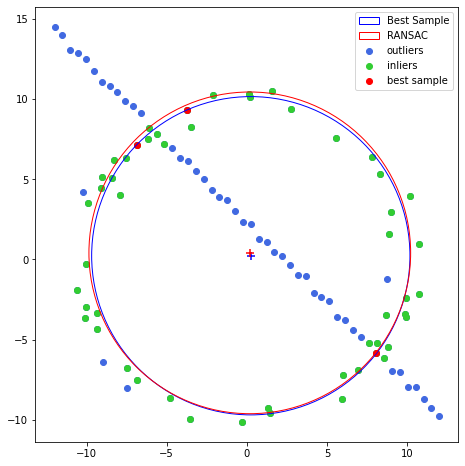

In [131]:
# ------------------------- tuning the parameters --------------------------- 
N = 35      # number of estimations 
t = 1.225   # common threshold 
d = 47      # minimum inlier count 

# -------------------- finding the best fitting circle ----------------------
(xO, yO, r, i1, i2, i3, xc, yc, R, Error), inliers = RANSACcircle(X, N, t, d) 
# ------------------------- plotting the results ----------------------------
plotting(1) 

<font size="2"> 

#### Question 4 - Computing the Best Homography using RANSAC Method 


<font size="2"> 

We dicussed RANSAC algorithm in the question 1 in the context of finding the best fit circle. Now, we will use the same steps to find the **best homography** between 2 images. 
- step 1 - randomly choose 4 matching keypoint pairs. [$s= 4$]
- step 2 - find the *corresponding homography* 
- step 3 - finding the *Inlier* count of the corresponding transformation. 
> + Let *A* and *B* be two matching keypoints on image 1 and image 2. And take point *C* as the projection of point *A* on image 2 under the estimated transformation. Then, point *B* is considered as an inlier under the homography if and only if the distacnce from C to B is less than some threshold value, $t$. 
> + Since the size of all the Graffiti images are (640, 800) in pixels, let us take 10 pixels as a suitable value for $t$. 
- step 4 - if there are $d$ or more inliers, accept the estimation. 
> + To find a value for $d$, we have to get an idea about the number of inliers in the matches. Firstly, we will take some radom sets of matching pairs and visualize them on the image using `cv.drawMatches` opencv function. Then, we will manually count the correct and incorrect matches in those sets and take an average value for the inlier ratio of the matches. 
> Take 5 sample with size of 5. 
> > sample 1 - correct = 5, incorrect = 0, inlier ratio = 100% [0:5]
> > sample 2 - correct = 5, incorrect = 0, inlier ratio = 100% [200:205]
> > sample 3 - correct = 4, incorrect = 1, inlier ratio =  80% [400:405]
> > sample 4 - correct = 5, incorrect = 0, inlier ratio = 100% [700:705]
> > sample 5 - correct = 5, incorrect = 0, inlier ratio = 100% [1000:1005]
> > sample 6 - correct = 0, incorrect = 5, inlier ratio = 0% [1300:1305] 

Then, the number of repetition required can be found as follows. Here, $ \ p = 0.99 \ (= 99$ % $), \ e \ {\small (outlier\ ratio)} = 0.5 \ {\small[for \ worst \ case]} $. 

$ N = log(1-p) / log(1 - (1-e)^s) = log(1-0.99) / log(1 - (1-0.5)^4) = 71.36 \backsimeq 72 $ 

Finally, the homography with the maximum inlier count is chosen as the **best estimation**, and the **final homography** is computed as the least-squre estimation of those inliers. 

In [50]:
# --------------------- opening the two images (img1 and 5) -----------------
imgQ = cv.imread("graf/img1.ppm", cv.IMREAD_GRAYSCALE); assert imgQ is not None # query image 
imgT = cv.imread("graf/img2.ppm", cv.IMREAD_GRAYSCALE); assert imgT is not None # train image 
print(imgQ.shape, imgT.shape)

(640, 800) (640, 800)


(2678,)


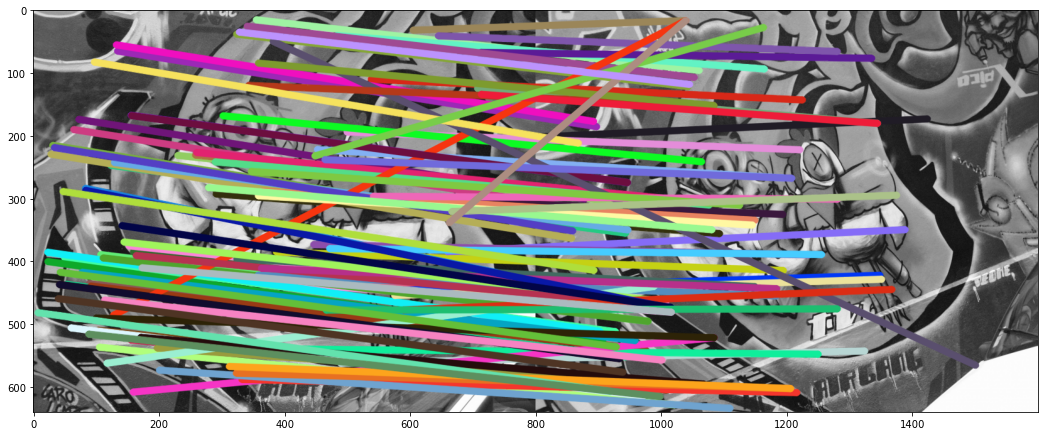

In [51]:
# ******************************************** question 3 ****************************************** 
# ======================== part (a) - Computing and Matching SIFT Features ========================= 
SIFT = cv.SIFT_create()             # initializing SIFT detector 
keysQ, descriptorsQ = SIFT.detectAndCompute(imgQ, None) # query image keypoints and descriptors 
keysT, descriptorsT = SIFT.detectAndCompute(imgT, None) # train image keypoints and descriptors 

bf = cv.BFMatcher()  # initializing Brute Force Matcher with default parameters for SIFT features 
matches = bf.match(descriptorsQ, descriptorsT); print(np.array(matches).shape) 
matches = sorted(matches, key = lambda x:x.distance)[:100] 

# visualizing the matches 
thickness = 10 
imgM = cv.drawMatches(imgQ, keysQ, imgT, keysT, matches[:], None, matchesThickness=thickness, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig, ax = plt.subplots(figsize=(18, 9)); ax.imshow(imgM) 

In [ ]:

def squareErrorDistance(DMatch, keysQ, keysT, H): 
    "return the square of the distance between keypoint2 and the transformation of keypoint1 on image 2"
    kpoint1, kpoint2 = keysQ[DMatch.queryIdx], keysT[DMatch.trainIdx] 
    (x, y) = kpoint1.pt; (x_, y_) = kpoint2.pt  # keypoint 1 (on image1) and keypoint 2 (on image2)
    X_t = (H @ np.array([[x], [y], [1]])).reshape(3, ) 
    (x_t, y_t, I) = X_t / X_t[2]                # transformation of keypoint 1 on image2 
    squareError = (x_-x_t)**2 + (y_-y_t)**2     # sqaure of distance between keypoint2 and transfomed point 
    print(kpoint1.pt); print(kpoint2.pt); print((x_t, y_t)) 
    return squareError 

def avgLeastSqureError(matches, H): 
    "return the average error of a homography wrt a given inlier set"
    sum = 0
    for match in matches: sum += squareErrorDistance(match, H) 
    return (sum / len(matches)) 

def leastSqaureHomography(inlierMatches, keysQ, keysT): 
    # if not len(inlierMatches) >= 4: print("Error - not enough matches to determine a homography") 
    A = np.array([]) # initialize an empty array 
    for match in inlierMatches: 
        kpoint1, kpoint2 = keysQ[match.queryIdx], keysT[match.trainIdx]
        (x, y) = kpoint1.pt; (x_, y_) = kpoint2.pt 
        X = np.array([x, y, 1]) # homogeneous coordinate of key point on query image 
        O = np.zeros(X.shape)   # zero vecotor with the same shape as X 
        A_X = np.array([np.concatenate((X, O, -x_*X)),
                        np.concatenate((O, X, -y_*X))]) 
        # print("A_X ="); print(A_X) 
        A = np.vstack((A, A_X))     if A.any() else A_X 
        # print("A ="); print(A)

    # the homography Matrix H can be obtained from the eigen vector of (A.T @ A) that corresponds to the smallest eigen value. 
    evalues, evectors = np.linalg.eig(A.T @ A) 
    i_min = min(range(len(evectors)), key = lambda i: evalues[i]) 
    h = evectors[i_min] 
    # print(h)
    H = h.reshape((3, 3)) 
    return A 

def RANSACHomography(matches, keysQ, keysT, N, t, d): 
    candidateHomograhpies = [] 
    for iteration in range(N): # perform N number of estimations 
        print("I'm in loop")
        # ---------------------- step (1) - randomly choose 4 matching keypoint pairs ---------------------- 
        (i1, i2, i3, i4) = np.random.randint(0, len(matches), 4) # finding 4 random indices in 'matches' array
        if (len(set((i1, i2, i3, i4))) < 4): N += 1; continue    # if the points are not distinct, then reject the sample and take a new one 
        sample = np.array([matches[i1], matches[i2], matches[i3], matches[i4]]) 
        print(i1, i2, i3, i4)
        # ------------------------ step (2) - finding the corresponding homography ------------------------- 
        H = leastSqaureHomography(sample, keysQ, keysT) 
        print(H)
        # -------------------------------- step (3) - finding the inliers ---------------------------------- 
        inlierMatches = []; t = 10 
        for match in matches: 
            if squareErrorDistance(match, H) <= t**2: inlierMatches.append(match) 
        print(len(inlierMatches))
        # ------------- step (4) - if there are 'd' or more inliers, then accept the estimation ------------ 
        if len(inlierMatches) >= int(len(matches) * d): candidateHomograhpies.append(inlierMatches) 

    max_inlier_count = max([len(inlierMatches) for inlierMatches in candidateHomograhpies]) 
    best_estimations = [inlierMatches for inlierMatches in candidateHomograhpies if len(inlierMatches) == max_inlier_count] 
    if len(best_estimations) == 1: best_homography = leastSqaureHomography(best_estimations[0], keysQ, keysT) 
    else: 
        minError = 10**6
        for inlierMatches in best_estimations: 
            H = leastSqaureHomography(inlierMatches, keysQ, keysT) 
            if avgLeastSqureError(inlierMatches, H) < minError: best_homography = H 
    return best_homography

In [150]:
# ******************* defining parameters *******************
N = 10 # number of sampling 
t = 10 # threshold for inliers 
d = 0.5 # consensus set size as a ratio of the total matches 

H = RANSACHomography(matches[:4], keysQ, keysT, N, t, d) 
H 

I'm in loop
I'm in loop
I'm in loop
2 3 0 1
A_X =
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.30068253e+02
   2.31079865e+02  1.00000000e+00 -7.24303417e+04 -7.27488185e+04
  -3.14821106e+02]
 [ 2.30068253e+02  2.31079865e+02  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -5.19054950e+04 -5.21337239e+04
  -2.25609116e+02]]
A_X =
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  7.90694519e+02
   2.02353134e+02  1.00000000e+00 -1.36690241e+05 -3.49815233e+04
  -1.72873642e+02]
 [ 7.90694519e+02  2.02353134e+02  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -4.92890654e+05 -1.26139699e+05
  -6.23364197e+02]]
A_X =
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.55091858e+02
   1.51441498e+01  1.00000000e+00 -3.39539982e+04 -1.44808850e+03
  -9.56203232e+01]
 [ 3.55091858e+02  1.51441498e+01  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -9.23827255e+04 -3.93998849e+03
  -2.60165710e+02]]
A_X =
[[ 0.00000000e+00  0.00

TypeError: squareErrorDistance() missing 2 required positional arguments: 'keysT' and 'H'

In [81]:
H1 = np.array([[8.7976964e-01,  3.1245438e-01, -3.9430589e+01],
              [-1.8389418e-01,  9.3847198e-01,  1.5315784e+02],
              [ 1.9641425e-04, -1.6015275e-05,  1.0000000e+00]])
# for i in range(4): print(squareErrorDistance(matches[i], keysQ, keysT, H))
H = leastSqaureHomography(matches[:4], keysQ, keysT) 
evalues, evectors = np.linalg.eig(H.T @ H)
i_min = min(range(len(evectors)), key = lambda i: evalues[i]) 
h = evectors[i_min] 
# print(h)
H = h.reshape((3, 3)) 
I = H @ H1
I = I / I[0][0]
I

array([[ 1.00000000e+00,  2.97973355e+00,  3.34093568e+02],
       [-1.31326216e-03,  1.62890789e-03,  3.65759870e-01],
       [ 1.11604759e-03,  3.96854383e-04, -4.99480879e-02]])

In [ ]:
manuallyfoundevecotrcorrstosmallestevalue = [[-5.41285732e-01, -8.40836578e-01, -9.76368629e-04],
                                             [ 3.40006952e-04, -6.71395961e-04, -1.38555800e-03],
                                             [-4.07980930e-04, -1.55365373e-07, -7.27353736e-07]]

(1398,)


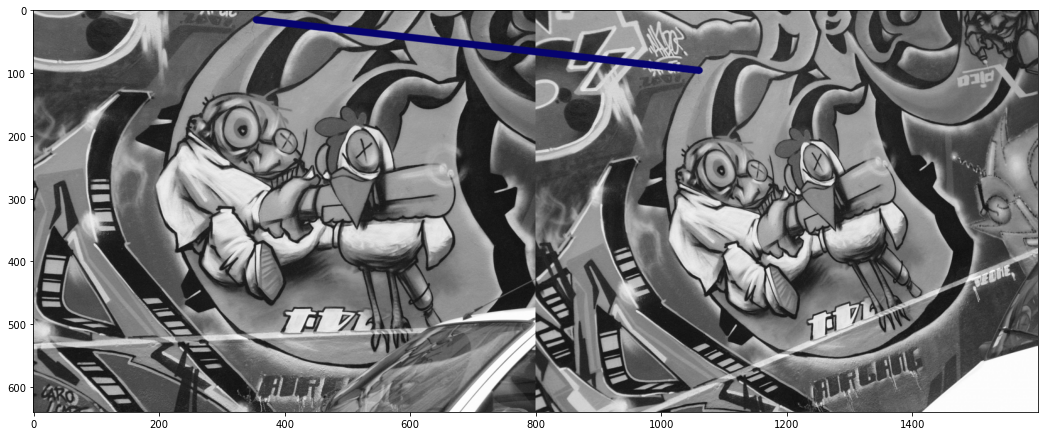

In [82]:
# ******************************************** question 3 ****************************************** 
# ======================== part (a) - Computing and Matching SIFT Features ========================= 
SIFT = cv.SIFT_create()             # initializing SIFT detector 
keysQ, descriptorsQ = SIFT.detectAndCompute(imgQ, None) # query image keypoints and descriptors 
keysT, descriptorsT = SIFT.detectAndCompute(imgT, None) # train image keypoints and descriptors 

bf = cv.BFMatcher(crossCheck=True)  # initializing Brute Force Matcher with default parameters for SIFT features 
matches = bf.match(descriptorsQ, descriptorsT); print(np.array(matches).shape) 
matches = sorted(matches, key = lambda x:x.distance)[:100] 

# visualizing the matches 
thickness = 10 
imgM = cv.drawMatches(imgQ, keysQ, imgT, keysT, matches[:1], None, matchesThickness=thickness, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig, ax = plt.subplots(figsize=(18, 9)); ax.imshow(imgM)

In [148]:
A = np.zeros((1, 9))
for i in range(4): 
    match = matches[i] 
    (x1, y1) = keysQ[match.queryIdx].pt 
    (x2, y2) = keysT[match.trainIdx].pt 
    print(x1, y1, "    ", x2, y2) 
    row1 = np.array([x1, y1,  1,  0,  0,  0, -x2*x1, -x2*y1, -x2]).astype(np.float64) 
    row2 = np.array([ 0,  0,  0, x1, y1,  1, -y2*x1, -y2*y1, -y2]).astype(np.float64) 
    A = np.vstack((A, row1)) 
    A = np.vstack((A, row2)) 
A = A[1: ] 
val, vect = np.linalg.eig(np.dot(A.T, A)); val = val.astype(np.float64); vect = vect.astype(np.float64)

i = 7
lamda = val[i] 
h = vect[:, i]
H = h.reshape((3, 3)) 
# lhs = lamda * h 
# rhs = np.dot(np.dot(A.T, A), h) 
# print(lhs); print(rhs)

# let's see right now, whether H is the correct homography 
xs, ys = keysQ[matches[0].queryIdx].pt 
xd, yd = keysT[matches[0].trainIdx].pt 
# we must have C * (xd, yd, 1) = H * (xs, ys, 1) 
B = H @ np.array((xs, ys, 1)) 
B = B / B[2] 
print("the projection of pt1 = \n", B) 
print("the matching point, pt2 = \n", [xd, yd, 1]) 

355.09185791015625 15.144149780273438      260.16571044921875 95.62032318115234
489.34014892578125 561.9087524414062      523.6778564453125 542.4274291992188
230.06825256347656 231.07986450195312      225.60911560058594 314.82110595703125
790.6945190429688 202.35313415527344      623.3641967773438 172.87364196777344
the projection of pt1 = 
 [260.16571124  95.62032324   1.        ]
the matching point, pt2 = 
 [260.16571044921875, 95.62032318115234, 1]


In [114]:
import numpy as np 
from numpy import linalg as LA 
B = np.array([[1,2,3],[3,2,1],[1,0,-1]]) 
w, v = LA.eig(np.dot(A.T, A))
print(w); print(v)

[5.64501525e+11 5.55266864e+10 1.23553834e+06 2.42998147e+05
 9.67845018e+04 1.09456389e+04 4.25844692e+03 1.30879458e-09
 5.26899001e-02]
[[ 1.08049005e-03 -1.56412323e-03  3.91628255e-01  4.06090971e-01
  -3.83102469e-01  6.40420438e-01 -3.53217961e-01  5.74698852e-03
  -3.46758556e-03]
 [ 5.77624712e-04  5.67178562e-04  2.94151966e-01  6.03229520e-01
   2.02723193e-01 -6.27725285e-01 -3.38301656e-01  1.99977177e-03
  -6.12609617e-04]
 [ 1.78767578e-06 -1.49423816e-06  7.90436010e-04  1.61750058e-03
  -2.16239997e-03  2.14440868e-03 -5.15495319e-03 -2.90820676e-01
   9.56757185e-01]
 [ 5.83317203e-04  3.38923240e-04 -7.86136780e-01  5.74120887e-01
   1.06885485e-01  1.99455827e-01  3.41305484e-02 -1.10678209e-03
  -6.79137726e-04]
 [ 4.76208461e-04  1.06385038e-03 -3.76465988e-01 -3.15442737e-01
  -4.23585540e-01 -2.24351700e-01 -7.27303783e-01  5.98047898e-03
  -1.71101753e-03]
 [ 1.15438362e-06  1.31177852e-06 -1.40838439e-03  7.79886917e-04
  -1.20498793e-03 -2.39330976e-03  9.013

In [116]:
u = v[:,1]
print(u) 
lam = w[1] 
print(lam)
print(np.dot(np.dot(A.T, A), u))
print(lam*u)

[-1.56412323e-03  5.67178562e-04 -1.49423816e-06  3.38923240e-04
  1.06385038e-03  1.31177852e-06  5.41285340e-01 -8.40836578e-01
 -1.22297015e-04]
55526686350.3761
[-8.68505803e+07  3.14935461e+07 -8.29700939e+04  1.88192844e+07
  5.90720865e+07  7.28387144e+04  3.00557813e+10 -4.66888689e+10
 -6.79074800e+06]
[-8.68505803e+07  3.14935461e+07 -8.29700939e+04  1.88192844e+07
  5.90720865e+07  7.28387144e+04  3.00557813e+10 -4.66888689e+10
 -6.79074800e+06]
